In [385]:
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
import pandas as pd
import os
import random
from urllib.request import urlretrieve
from sklearn.linear_model import LinearRegression
import scipy
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, formatter={'float': '{: 0.6f}'.format})

%reload_ext version_information
%version_information numpy, pandas, seaborn, urllib.request, random, sklearn, scipy, seaborn

Software,Version
Python,3.7.4 64bit [GCC 7.3.0]
IPython,7.8.0
OS,Linux 4.15.0 66 generic x86_64 with debian buster sid
numpy,1.17.2
pandas,0.25.1
seaborn,0.9.0
urllib.request,3.7
random,The 'random' distribution was not found and is required by the application
sklearn,0.21.3
scipy,1.3.1


In [386]:
url = 'http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz'
npz_file_name = "../data/" + 'fishing.npz'

if not os.path.isfile(npz_file_name):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz', npz_file_name)
else:
    print("File already downloaded.")
    d = np.load(npz_file_name)

File already downloaded.


In [387]:
header = ["livebait", "camper", "person", "children"]
train_data = np.asarray(d['Xt'])
test_data = np.asarray(d['Xte'])
train_labels = np.asarray(d['yt'])
test_labels = np.asarray(d['yte'])
n_train_data, n_test_data = 200, 50

In [388]:
%%latex
\begin{align}
Weights: & \quad \mathbf{\hat{w}} && = (X^T X)^{-1} X^T \mathbf{y}  \\
Intercept: & \quad \hat{w}_0 && = \bar{y} - \langle \mathbf{\hat{w}}, \bar{\mathbf{x}} \rangle \\
Estimate: & \quad \mathbf{\hat{y}} && = \langle \mathbf{\hat{w}}, \mathbf{x} \rangle + \hat{w}_0 \\
\end{align}

<IPython.core.display.Latex object>

### a) Lineare Regression wie in Vorlesung

In [389]:
_w = np.linalg.inv(train_data.T @ train_data) @ train_data.T @ train_labels
_intercept = np.mean(train_labels) - _w @ np.mean(train_data, axis=0)
_y = np.sum(_w.T * train_data, axis=1) + _intercept
print("Intercept: {}, Weights: {}".format(_intercept, _w))

Intercept: -0.6354212760925293, Weights: [-1.699983  1.619098  3.162473 -5.049979]


### b) Lineare Regression mit sklearn

In [390]:
reg = LinearRegression().fit(train_data, train_labels)
_w = reg.coef_
_intercept = reg.intercept_
_y = np.sum(_w.T * train_data, axis=1) + _intercept
print("Intercept: {}, Weights: {}".format(_intercept, _w))

Intercept: -8.492233276367188, Weights: [ 2.482213  2.954309  4.649542 -5.471604]


### c) RMSE und NLL(Gauss) auf den Testdaten

In [391]:
%%latex
\begin{align}
Root \; Mean \; Square \; Error(RMSE): & \quad \sqrt{\frac{1}{N} \sum_{i=1}^{N}(\mathbf{y} - \mathbf{\hat{y}})^2} \\
Negative \; Log \; Likelihood(NLL): & \quad -\frac{1}{N} \sum_{i=1}^{N}log(p_{model}(y^{(i)}|x^{(i)};\theta)) \\
Probability \; density \; function(PDF): & \quad \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{align}

<IPython.core.display.Latex object>

In [408]:
_y = np.sum(_w.T * test_data, axis=1) + _intercept
rmse = np.sqrt(np.sum((test_labels - _y)**2) / n_test_data)
residuals = test_labels - _y
std = np.std(residuals)
var = np.var(residuals)
mean = np.mean(residuals)
cpd = [scipy.stats.norm(mean, std).pdf(residuals[i]) for i in range(n_test_data)]
nll = -np.sum(np.log(cpd)) / n_test_data
print("RMSE: {}, var: {}, NLL: {}".format(rmse, var, nll))

RMSE: 8.588126569208793, var: 73.48029327392578, NLL: 3.5674472059765203


### d) Plot Vergleich der Vorhersage und Testdaten

16.276258764266966 -17.326233682632445
0.00016503647819665065 0.0009306862408613739


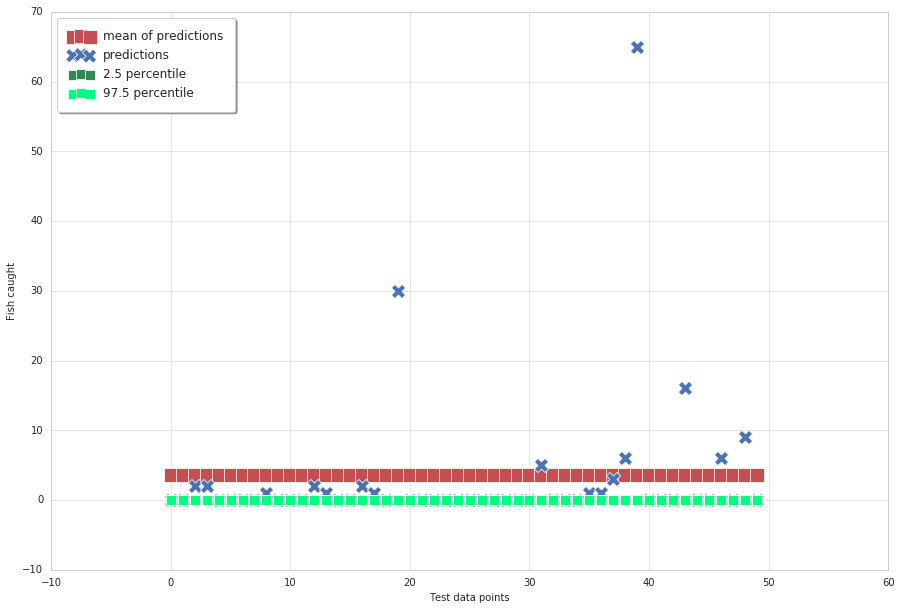

In [409]:
x = np.arange(n_test_data)
mean_y = np.mean(_y)
p1 = mean + 1.96 * std
p2 = mean - 1.96 * std
print(p1, p2)

cpd = np.asarray([scipy.stats.norm(mean, std).pdf(residuals[i]) for i in range(n_test_data)]) / n_test_data
p1 = np.percentile(cpd, 2.5)
p2 = np.percentile(cpd, 97.5)
print(p1, p2)

fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x, mean_y, marker="s", s=200, color='r', ax=ax, label='mean of predictions')
sns.scatterplot(x, test_labels, marker="X", s=200, color='b', ax=ax, label='predictions')
sns.scatterplot(x, p1, marker="s", s=100, color='seagreen', ax=ax, label='2.5 percentile')
sns.scatterplot(x, p2, marker="s", s=100, color='springgreen', ax=ax, label='97.5 percentile')
ax.set_title("")
ax.set_xlabel("Test data points")
ax.set_ylabel("Fish caught")
ax.legend(loc="upper left", fancybox=True, framealpha=1, shadow=True, borderpad=1)
sns.set_style("whitegrid")

### e) RMSE und NLL(Poisson) auf den Testdaten

In [394]:
_y = np.sum(_w.T * test_data, axis=1) + _intercept
rmse = np.sqrt(np.sum((test_labels - _y)**2) / n_test_data)
residuals = test_labels - _y
std = np.std(residuals)
var = np.var(residuals)
mean = np.mean(residuals)
nll = 0
print("RMSE: {}, \u03C3^2: {}, NLL: {}".format(rmse, var, nll))

RMSE: 8.588126569208793, σ^2: 73.48029327392578, NLL: 0


### f) Plot Vergleich der Vorhersage und Testdaten

16.276258764266966 -17.326233682632445


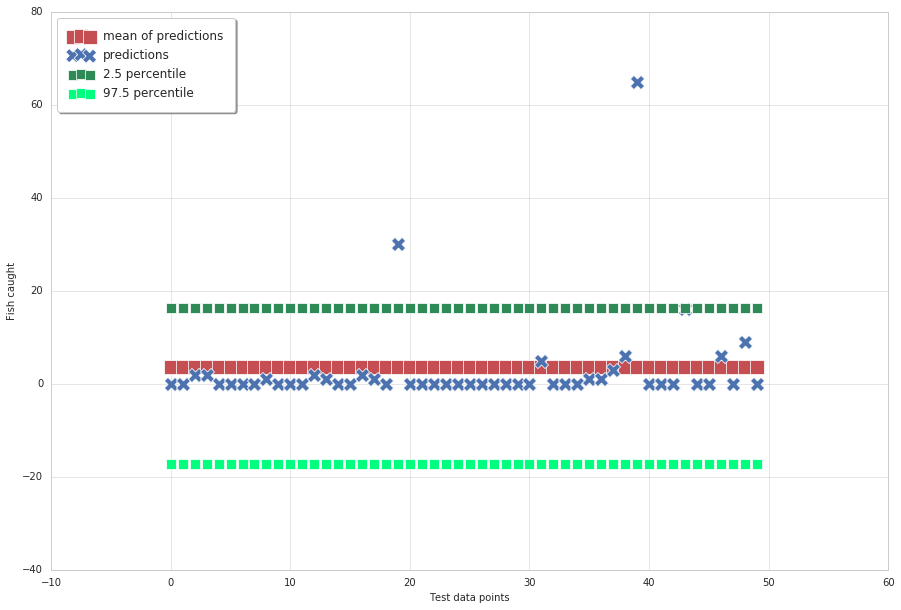

In [395]:
x = np.arange(n_test_data)
mean_y = np.mean(_y)
p1 = mean + 1.96 * std
p2 = mean - 1.96 * std
print(p1, p2)
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x, mean_y, marker="s", s=200, color='r', ax=ax, label='mean of predictions')
sns.scatterplot(x, test_labels, marker="X", s=200, color='b', ax=ax, label='predictions')
sns.scatterplot(x, p1, marker="s", s=100, color='seagreen', ax=ax, label='2.5 percentile')
sns.scatterplot(x, p2, marker="s", s=100, color='springgreen', ax=ax, label='97.5 percentile')
ax.set_title("")
ax.set_xlabel("Test data points")
ax.set_ylabel("Fish caught")
ax.legend(loc="upper left", fancybox=True, framealpha=1, shadow=True, borderpad=1)
sns.set_style("whitegrid")